Text Analytics Project 2 - Sentiment Analysis

##### Imports

In [ ]:
#Necessary Imports
import math 
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import warnings 
import os
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import pandas as pd
import time
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import WhitespaceTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import sem
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
from sklearn.metrics import roc_auc_score
import csv
import gzip
import urllib.request
import requests
import nltk
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Downloading Stopwords & Dictionary
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)

#Downloading data(In compressed form) provided by Stanford University
!wget -q  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

#Unzipping data
!tar  xzf aclImdb_v1.tar.gz

In [ ]:
#Setting random seed so we can analyse results
np.random.seed(365)

##### Loading Data

In [ ]:
#Initializing Function to load data
def load_train_test_imdb_data(data_dir):
    """Loads the IMDB train/test datasets from a folder path.
    Input:
    data_dir: path to the "aclImdb" folder.
    
    Returns:
    train/test datasets as pandas dataframes.
    """

    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
          #Renaming sentiment to values 
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r") as f:
                    review = f.read()
                    data[split].append([review, score])
    #Shuffling train data
    np.random.shuffle(data["train"])        
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['text', 'sentiment'])
     #Shuffling test data
    np.random.shuffle(data["test"])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['text', 'sentiment'])
    return data["train"], data["test"]

In [ ]:
train_data, test_data = load_train_test_imdb_data(
    data_dir="aclImdb/")

In [ ]:
#Combining them together
newdf=pd.concat([train_data,test_data],ignore_index=True)

### Preprocessing + Learning Curves Function

In [ ]:
#Splitting our dataset into train & test
train_data,test_data = train_test_split(newdf,train_size=0.7,random_state=1)

#Splitting our test set into dev & test 
dev_data,test_data = train_test_split(test_data, test_size =  0.6 ,random_state=1)

#Checking lengths
print('Train length',train_data.shape[0])
print('Dev length',dev_data.shape[0])
print('Test length',test_data.shape[0])

Train length 35000
Dev length 6000
Test length 9000


In [ ]:
#Average train document length
train_data['countWords'] = train_data.text.str.count(' ') + 1
average=train_data.countWords.sum()/len(train_data)
print('We have an average of ',round(average),'words per review for the train set.')

We have an average of  232 words per review for the train set.


In [ ]:
#Init lemmatizer
lemmzer = WordNetLemmatizer() 

In [ ]:
#Preprocessing Function
def prep(corpus): # fun to preprocess the corpus # allagi 
  corpus= corpus.apply(lambda x:x.lower()) #Lowercase
  corpus= corpus.apply(lambda x:re.sub(r'<.*?>', ' ', x)) #Remove html tags
  corpus= corpus.apply(lambda x: re.sub(r'\W', ' ', str(x))) #Remove punctuation
  corpus= corpus.apply(lambda x:re.sub('\d+', ' ', x)) #Remove numbers
  corpus= corpus.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x)) #Remove single characters
  corpus= corpus.apply(lambda x:re.sub(r'\s+', ' ',x)) #Remove multiple spaces
  corpus= corpus.apply(lambda x:[lemmzer.lemmatize(word) for word in x.split()]) #Running Lemmatizer by splitting the sentences into words
  corpus= corpus.apply(lambda x:' '.join(x)) #Re-forming the previously split sentences
  return corpus

In [ ]:
#Running prep on our dataset
train_data.text=prep(train_data.text)
dev_data.text=prep(dev_data.text)
test_data.text = prep(test_data.text)

#Renaming our target values
y_train = train_data.sentiment
y_dev = dev_data.sentiment
y_test = test_data.sentiment

In [ ]:
#Init TFIDF
vectorizer = TfidfVectorizer(
    ngram_range = (1, 2), 
    max_features = 7500,
    sublinear_tf = True, 
    stop_words = stopwords.words('english'))

In [ ]:
#Vocabulary Size
VocabSize = TfidfVectorizer( 
    sublinear_tf = True, 
    stop_words = stopwords.words('english'))
vocabsize = VocabSize.fit_transform(train_data.text)
print("Train dataset's vocabulary size is",vocabsize.shape[1],"words long.")

Train dataset's vocabulary size is 78098 words long.


In [ ]:
#Dataframe with train and dev data for our Grid Search
param=pd.concat([train_data,dev_data],axis=0)
y_param=param.sentiment

In [ ]:
#Transforming all text datasets
x_train_tfidf = vectorizer.fit_transform(train_data.text)
x_test_tfidf = vectorizer.transform(test_data.text)
x_dev_tfidf = vectorizer.transform(dev_data.text)
x_param_tfidf=vectorizer.transform(param.text)

# get_feauture_names() for a more thorough view
print(vectorizer.get_feature_names()) 

['aaron', 'abandoned', 'abc', 'ability', 'able', 'able see', 'abortion', 'abraham', 'abruptly', 'absence', 'absent', 'absolute', 'absolutely', 'absolutely nothing', 'absurd', 'absurdity', 'abuse', 'abused', 'abusive', 'abysmal', 'academy', 'academy award', 'accent', 'accept', 'acceptable', 'acceptance', 'accepted', 'access', 'accident', 'accidentally', 'acclaimed', 'accompanied', 'accomplish', 'accomplished', 'according', 'account', 'accuracy', 'accurate', 'accurately', 'accused', 'ace', 'achieve', 'achieved', 'achievement', 'acid', 'across', 'act', 'act like', 'acted', 'acting', 'acting ability', 'acting bad', 'acting film', 'acting good', 'acting great', 'acting like', 'acting movie', 'acting skill', 'acting talent', 'acting terrible', 'acting wa', 'action', 'action film', 'action flick', 'action movie', 'action packed', 'action scene', 'action sequence', 'active', 'activity', 'actor', 'actor actress', 'actor film', 'actor good', 'actor great', 'actor like', 'actor movie', 'actor pla

In [ ]:
print('Shape of training data: {}\n'.format(x_train_tfidf.shape))
print('Shape of test data: {}\n'.format(x_test_tfidf.shape))
print('Shape of dev data: {}\n'.format(x_dev_tfidf.shape))
print('Shape of param data: {}\n'.format(x_param_tfidf.shape))

#print(x_test_tfidf[0, :])  # Sparce matrix --> Saves only the cells which are not zero

Shape of training data: (35000, 7500)

Shape of test data: (9000, 7500)

Shape of dev data: (6000, 7500)

Shape of param data: (41000, 7500)



In [ ]:
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# palette = sns.color_palette("bright", 2)

# # Dimensionality reduction using TSNE
# tsne = TSNE(n_components=2, random_state=4321)
# x_train_trunc = tsne.fit_transform(x_train_tfidf)

# plt.figure()
# plt.title('TSNE Reduction')
# sns.scatterplot(x_train_trunc[:,0], x_train_trunc[:,1], hue=train_data.sentiment, legend='full', palette=palette)

# # Dimensionality Reduction using SVD
# svd = TruncatedSVD(n_components=2, random_state=4321)
# x_train_trunc = svd.fit_transform(x_train_tfidf)

# plt.figure()
# plt.title('SVD Reduction')
# sns.scatterplot(x_train_trunc[:,0], x_train_trunc[:,1], hue=train_data.sentiment, legend='full', palette=palette)

In [ ]:
# Number of features to keep
k = 2500 # we tested for k= (500,1000,1500,2000,2500,3000,3750) with 1/3 of the total features we managed to get the same scores +- 1%

# Convert sparse matrix to np.array --> Slow
x_train_tfidf_array = x_train_tfidf.toarray()  

# The function relies on nonparametric methods 
# based on entropy estimation from k-nearest neighbors distances
mutual_information = mutual_info_classif(x_train_tfidf_array,train_data.sentiment, n_neighbors=5, 
                                         discrete_features=True,
                                         random_state=4321)

# Indexes of the feature columns
indexes = np.arange(len(mutual_information))

# Sort by mutual information values --> (value, idx)
sorted_indexes = sorted(zip(mutual_information, indexes), reverse=True)
print('Sorted indexes: {}'.format(sorted_indexes[:4]))

# keep the indexes of the best k features
best_idxs = [idx for val, idx in sorted_indexes[:k]]
print('Best indexes: {}\n'.format(best_idxs[:4]))

# Keep only the colums of the best features
x_train_best_tfidf = x_train_tfidf_array[:, best_idxs]
x_test_best_tfidf = x_test_tfidf[:, best_idxs]
x_dev_best_tfidf = x_dev_tfidf[:, best_idxs]
print('Shape of training data: {} --> {}'.format(x_train_tfidf.shape, x_train_best_tfidf.shape))
print('Shape of test data: {} --> {}\n'.format(x_test_tfidf.shape, x_test_best_tfidf.shape))

Sorted indexes: [(0.4538387895361379, 4216), (0.4468761809532651, 7025), (0.40740239939430073, 2285), (0.4025259656824445, 4613)]
Best indexes: [4216, 7025, 2285, 4613]

Shape of training data: (35000, 7500) --> (35000, 2500)
Shape of test data: (9000, 7500) --> (9000, 2500)



In [ ]:
#Replacing tfidf with the one above(k best features)
x_train_tfidf = x_train_best_tfidf
x_test_tfidf = x_test_best_tfidf
x_dev_tfidf = x_dev_best_tfidf


In [ ]:
#Learning Curves Init
def F1_Curves(function,title):
  #Split into 5 parts/Round numbers
  parts = np.linspace(0.20,1,5)*x_train_tfidf.shape[0]
  #Init lists
  trainlist = []
  testlist = []
  devlist = []
  for p in parts:
    estimator = function
    #Fit with part of the data / Increases for every loop
    estimator.fit(x_train_tfidf[:int(p)],y_train[:int(p)])
    #Saving scores
    trainlist.append(f1_score(y_train[:int(p)],estimator.predict(x_train_tfidf[:int(p)]),average='macro'))
    testlist.append(f1_score(y_test,estimator.predict(x_test_tfidf),average='macro'))
    devlist.append(f1_score(y_dev,estimator.predict(x_dev_tfidf),average='macro'))
  #Plotting lines
  plt.plot(parts,trainlist,label='Train Score')
  plt.plot(parts,testlist,label='Test Score')
  plt.plot(parts,devlist,label='Dev Score')
  plt.xlabel('Training Examples')
  plt.ylabel('F1 Score')
  plt.legend(loc='lower right')
  plt.title('Learning Curves for '+title)
  plt.show()

### Dummy Classifier

Training took: 0.002900362014770508 seconds 

Train accuracy: 50.04% 

Dev accuracy: 50.08% 

Test accuracy: 49.80% 

#Class 0 in Train dataset: (17487,)
#Class 1 in Train dataset: (17513,)

Confusion Matrix for test data:


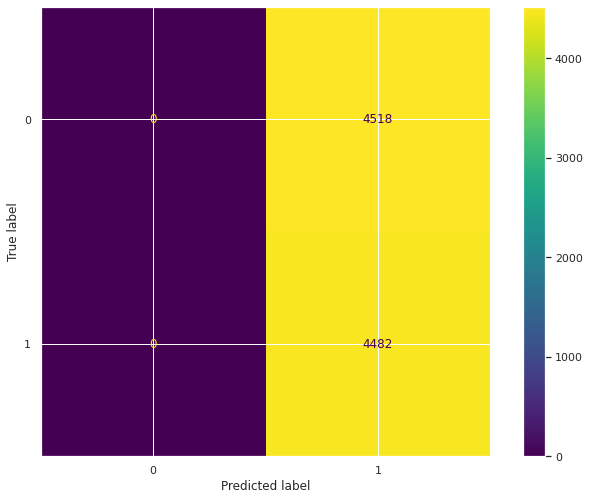

In [ ]:
# Train
# The dummy classifier always predicts the 'most frequent' class
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(x_train_tfidf, train_data.sentiment)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate on train,dev, and test subsets
predictions_train = baseline.predict(x_train_tfidf)
score = accuracy_score(train_data.sentiment, predictions_train)
print("Train accuracy: {:.2f}% \n".format(score*100))

predictions_dev = baseline.predict(x_dev_tfidf)
score = accuracy_score(dev_data.sentiment, predictions_dev)
print("Dev accuracy: {:.2f}% \n".format(score*100))

predictions_test = baseline.predict(x_test_tfidf)
score = accuracy_score(test_data.sentiment, predictions_test)
print("Test accuracy: {:.2f}% \n".format(score*100))

print('#Class 0 in Train dataset:', np.where(train_data.sentiment == 0)[0].shape)
print('#Class 1 in Train dataset:', np.where(train_data.sentiment == 1)[0].shape)

print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=baseline, X=x_test_tfidf, y_true=test_data.sentiment, values_format = '.0f');

In [ ]:
#Classification Report on train,dev,test datasets.

print('Dummy Classifier')
print('')
print('Train')
print(classification_report(y_train,predictions_train))
print('')
print('Dev')
print(classification_report(y_dev,predictions_dev))
print('')
print('Test')
print(classification_report(y_test,predictions_test))

Dummy Classifier

Train
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     17487
           1       0.50      1.00      0.67     17513

    accuracy                           0.50     35000
   macro avg       0.25      0.50      0.33     35000
weighted avg       0.25      0.50      0.33     35000


Dev
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2995
           1       0.50      1.00      0.67      3005

    accuracy                           0.50      6000
   macro avg       0.25      0.50      0.33      6000
weighted avg       0.25      0.50      0.33      6000


Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4518
           1       0.50      1.00      0.66      4482

    accuracy                           0.50      9000
   macro avg       0.25      0.50      0.33      9000
weighted avg       0.25      0.50      

In [ ]:
#Roc scores
print('Training AUC score = ',roc_auc_score(y_train,predictions_train))
print('Dev AUC score = ',roc_auc_score(y_dev,predictions_dev))
print('Test AUC score = ',roc_auc_score(y_test,predictions_test))

Training AUC score =  0.5
Dev AUC score =  0.5
Test AUC score =  0.5


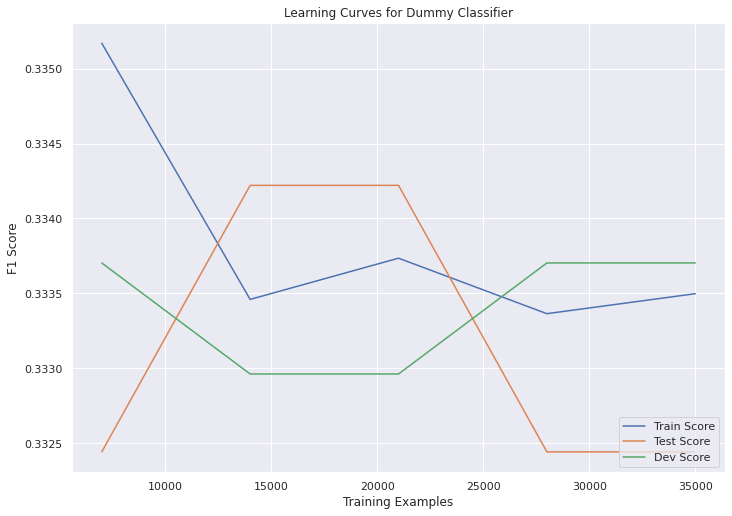

In [ ]:
F1_Curves(DummyClassifier(),'Dummy Classifier')


### MultinomialNB

In [ ]:
#Predefined Split
split_index =( [-1]*len(train_data))+([0]*len(dev_data))
pds = PredefinedSplit(test_fold = split_index)

In [ ]:
# Train
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')
clf = MultinomialNB()
#Grid for Grid Search
grid={'alpha' : np.linspace(0.1,2,30)}
#Fitting Grid Search
clf_cv=GridSearchCV(clf,grid,cv=pds, scoring=f1)
#Counter
start_time = time.time()
clf_cv.fit(x_param_tfidf, y_param)
print("Training took: {} seconds \n".format(time.time() - start_time))
print("tuned hyperparameters :(best parameters) ",clf_cv.best_params_)
print("accuracy :",clf_cv.best_score_)

Training took: 1.3532209396362305 seconds 

tuned hyperparameters :(best parameters)  {'alpha': 1.803448275862069}
accuracy : 0.8677864379173824


Train f1-score: 86.39%

Dev f1-score: 85.81% 

Test f1-score: 86.38% 


Confusion Matrix for test data:


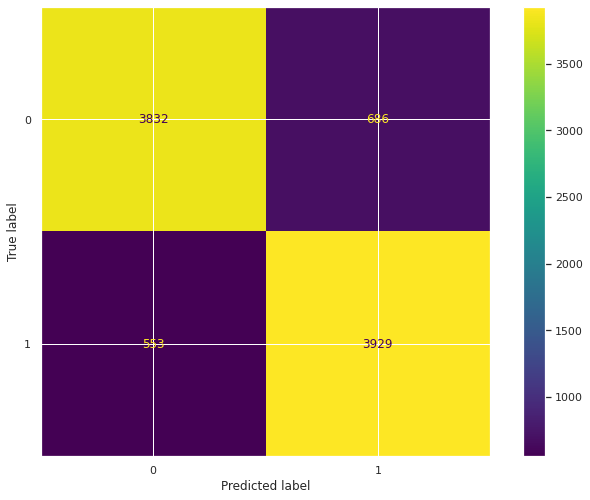

In [ ]:
#Train using the best parameters from Grid Search
#Naive is not a complex enough model and shows signs of underfitting in our learning curves
clf = MultinomialNB(alpha=clf_cv.best_params_['alpha'] ) 
clf.fit(x_train_tfidf, y_train)

# Evaluate on train,dev, and test subsets 
predictions_train = clf.predict(x_train_tfidf)
score = f1_score(y_train,predictions_train)
print("Train f1-score: {:.2f}%\n".format(score*100))

predictions_dev = clf.predict(x_dev_tfidf)
score = f1_score(y_dev, predictions_dev)
print("Dev f1-score: {:.2f}% \n".format(score*100))

predictions_test = clf.predict(x_test_tfidf)
score = f1_score(y_test, predictions_test)
print("Test f1-score: {:.2f}% \n".format(score*100))

print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=clf, X=x_test_tfidf, y_true=y_test, values_format = '.0f');

In [ ]:
#Classification Report on train,dev,test datasets.

print('Naive Bayes Classifier')
print('')
print('Train')
print(classification_report(y_train,predictions_train))
print('')
print('Dev')
print(classification_report(y_dev,predictions_dev))
print('')
print('Test')
print(classification_report(y_test,predictions_test))

Naive Bayes Classifier

Train
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     17487
           1       0.85      0.88      0.86     17513

    accuracy                           0.86     35000
   macro avg       0.86      0.86      0.86     35000
weighted avg       0.86      0.86      0.86     35000


Dev
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      2995
           1       0.84      0.87      0.86      3005

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000


Test
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4518
           1       0.85      0.88      0.86      4482

    accuracy                           0.86      9000
   macro avg       0.86      0.86      0.86      9000
weighted avg       0.86      0.86

In [ ]:
#Area Under the Curve score

print('Training AUC score = ',roc_auc_score(y_train,predictions_train))
print('Dev AUC score = ',roc_auc_score(y_dev,predictions_dev))
print('Test AUC score = ',roc_auc_score(y_test,predictions_test))

Training AUC score =  0.8610708653746163
Dev AUC score =  0.8553029313970317
Test AUC score =  0.8623902426883275


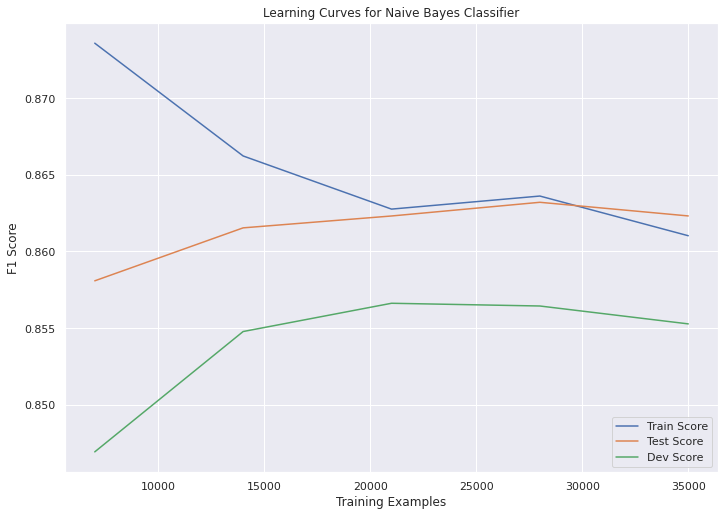

In [ ]:
F1_Curves(MultinomialNB(alpha=clf_cv.best_params_['alpha']),'Naive Bayes Classifier')

### Logistic Regression

In [ ]:
# Train
#Grid for Grid Search
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge

clf = LogisticRegression(solver="saga")
clf_cv=GridSearchCV(clf,grid,cv=pds,scoring=f1)
start_time = time.time()
clf_cv.fit(x_param_tfidf, y_param)
print("tuned hyperparameters :(best parameters) ",clf_cv.best_params_)
print("accuracy :",clf_cv.best_score_)
print("Training took: {} seconds \n".format(time.time() - start_time))

tuned hyperparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.8939717140094818
Training took: 386.3060026168823 seconds 



Train f1-score: 90.15%

Dev f1-score: 88.65% 

Test f1-score: 88.92% 


Confusion Matrix for test data:


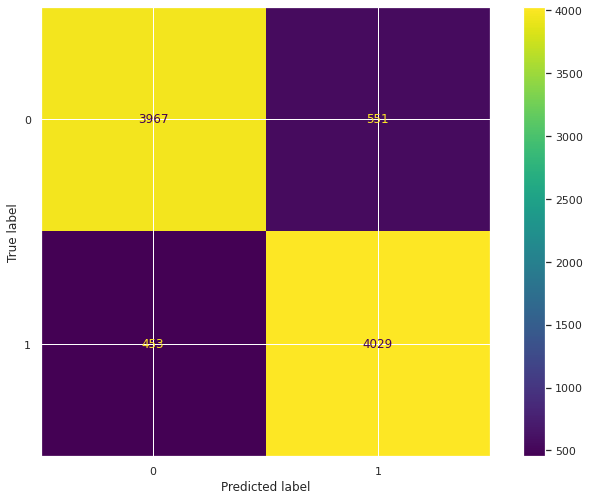

In [ ]:
#Train using the best parameters from Grid Search
clf = LogisticRegression(C=clf_cv.best_params_['C'],penalty=clf_cv.best_params_['penalty'], solver='saga' )
clf.fit(x_train_tfidf, y_train)

# Evaluate on train,dev, and test subsets 
predictions_train = clf.predict(x_train_tfidf)
score = f1_score(y_train,predictions_train)
print("Train f1-score: {:.2f}%\n".format(score*100))

predictions_dev = clf.predict(x_dev_tfidf)
score = f1_score(y_dev, predictions_dev)
print("Dev f1-score: {:.2f}% \n".format(score*100))

predictions_test = clf.predict(x_test_tfidf)
score = f1_score(y_test, predictions_test)
print("Test f1-score: {:.2f}% \n".format(score*100))

print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=clf, X=x_test_tfidf, y_true=y_test, values_format = '.0f');

In [ ]:
#Classification Report on train,dev,test datasets.

print('Logistic Regression')
print('')
print('Train')
print(classification_report(y_train,predictions_train))
print('')
print('Dev')
print(classification_report(y_dev,predictions_dev))
print('')
print('Test')
print(classification_report(y_test,predictions_test))

Logistic Regression

Train
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     17487
           1       0.89      0.91      0.90     17513

    accuracy                           0.90     35000
   macro avg       0.90      0.90      0.90     35000
weighted avg       0.90      0.90      0.90     35000


Dev
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      2995
           1       0.87      0.90      0.89      3005

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000


Test
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4518
           1       0.88      0.90      0.89      4482

    accuracy                           0.89      9000
   macro avg       0.89      0.89      0.89      9000
weighted avg       0.89      0.89   

In [ ]:
#Area Under the Curve score

print('Training AUC score = ',roc_auc_score(y_train,predictions_train))
print('Dev AUC score = ',roc_auc_score(y_dev,predictions_dev))
print('Test AUC score = ',roc_auc_score(y_test,predictions_test))

Training AUC score =  0.9002770421120657
Dev AUC score =  0.8843035675099097
Test AUC score =  0.8884862157794525


In [ ]:
#Setting up seaborne pallete
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)

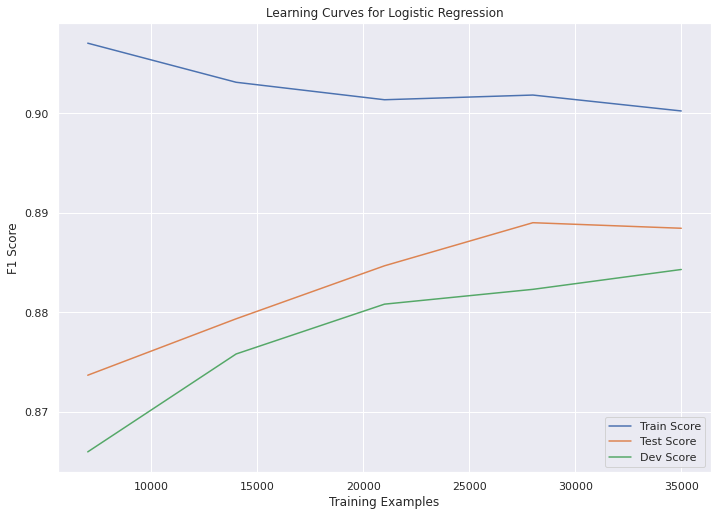

In [ ]:
F1_Curves(LogisticRegression(C=clf_cv.best_params_['C'],penalty=clf_cv.best_params_['penalty'], solver='saga'),"Logistic Regression")

### KNN

In [ ]:
# Train
#Grid for Grid Search
grid={"n_neighbors":np.arange(8,20)}
clf = KNeighborsClassifier()
clf_cv=GridSearchCV(clf,grid,cv=pds,scoring=f1)
start_time = time.time()
clf_cv.fit(x_param_tfidf, y_param)
print("tuned hyperparameters :(best parameters) ",clf_cv.best_params_)
print("accuracy :",clf_cv.best_score_)
print("Grid Search process took: {} seconds \n".format(time.time() - start_time))

tuned hyperparameters :(best parameters)  {'n_neighbors': 19}
accuracy : 0.8277538974443361
Grid Search process took: 147.66931700706482 seconds 



Training took: 0.0665280818939209 seconds 

Train f1-score: 78.35%

Dev f1-score: 69.48% 

Test f1-score: 69.66% 


Confusion Matrix for test data:


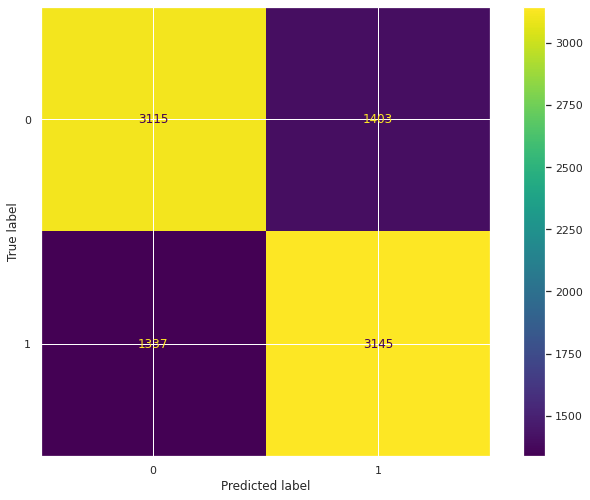

In [ ]:
#Train using the best parameters from Grid Search
clf2 = KNeighborsClassifier(n_neighbors=clf_cv.best_params_['n_neighbors'])
start_time = time.time()
clf2.fit(x_train_tfidf, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate on train,dev, and test subsets 
predictions_train = clf2.predict(x_train_tfidf)
score = f1_score(y_train,predictions_train)
print("Train f1-score: {:.2f}%\n".format(score*100))

predictions_dev=clf2.predict(x_dev_tfidf)
score = f1_score(y_dev, predictions_dev)
print("Dev f1-score: {:.2f}% \n".format(score*100))

predictions_test = clf2.predict(x_test_tfidf)
score = f1_score(y_test, predictions_test)
print("Test f1-score: {:.2f}% \n".format(score*100))

print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=clf2, X=x_test_tfidf, y_true=y_test, values_format = '.0f');

In [ ]:
#Classification Report on train,dev,test datasets.

print('KNeighborsClassifier')
print('')
print('Train')
print(classification_report(y_train,predictions_train))
print('')
print('Dev')
print(classification_report(y_dev,predictions_dev))
print('')
print('Test')
print(classification_report(y_test,predictions_test))

KNeighborsClassifier

Train
              precision    recall  f1-score   support

           0       0.78      0.78      0.78     17487
           1       0.78      0.78      0.78     17513

    accuracy                           0.78     35000
   macro avg       0.78      0.78      0.78     35000
weighted avg       0.78      0.78      0.78     35000


Dev
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      2995
           1       0.69      0.70      0.69      3005

    accuracy                           0.69      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.69      0.69      0.69      6000


Test
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      4518
           1       0.69      0.70      0.70      4482

    accuracy                           0.70      9000
   macro avg       0.70      0.70      0.70      9000
weighted avg       0.70      0.70  

In [ ]:
print('Training AUC score = ',roc_auc_score(y_train,predictions_train))
print('Dev AUC score = ',roc_auc_score(y_dev,predictions_dev))
print('Test AUC score = ',roc_auc_score(y_test,predictions_test))

Training AUC score =  0.7836866349160533
Dev AUC score =  0.6939974833263426
Test AUC score =  0.6955800181691796


In [ ]:
# # Reduce dimensionality using svd  7500 --> 1875
# from sklearn.decomposition import TruncatedSVD

# svd = TruncatedSVD(n_components=1875, random_state=4321)
# x_train_svd = svd.fit_transform(x_train_tfidf)
# x_test_svd = svd.transform(x_test_tfidf)

# # Train --Same as above
# clf = KNeighborsClassifier(n_neighbors=5)
# start_time = time.time()
# clf.fit(x_train_svd, y_train)
# print("Training took: {} seconds \n".format(time.time() - start_time))

# # Evaluate
# predictions = clf.predict(x_train_svd)
# score = f1_score(y_train,predictions)
# print("Train f1-score: {:.2f}%".format(score*100))

# predictions_test = clf.predict(x_test_svd)
# score = f1_score(y_test, predictions_test)
# print("Test f1-score: {:.2f}% \n".format(score*100))

# print("\nConfusion Matrix for test data:")
# plot_confusion_matrix(estimator=clf, X=x_test_svd, y_true=y_test, values_format = '.0f');

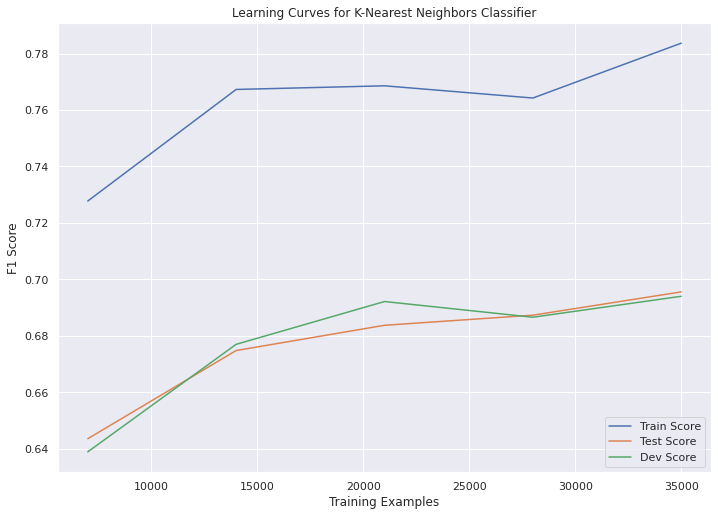

In [ ]:
#Runs in approx 10 minutes(?)
F1_Curves(KNeighborsClassifier(n_neighbors=clf_cv.best_params_['n_neighbors']),'K-Nearest Neighbors Classifier')